In [1]:
#Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from pathlib import Path

In [2]:
# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [3]:
#Load Data
df = pd.read_csv('texts.csv')
print(f"Loaded {len(df)} texts")
df.head()

Loaded 60 texts


,text_id,title,text
0,T0001,APOE ε4 allele and Alzheimer disease risk,The rs429358 variant in the APOE gene is stron...
1,T0002,TREM2 variants in neurodegeneration,"Rare coding variants in TREM2, including rs759..."
2,T0003,BIN1 locus and tau pathology,Common variants near BIN1 at rs744373 are asso...
3,T0004,CLU genetic associations in AD,The clusterin gene CLU contains several varian...
4,T0005,CR1 complement receptor variants,Variants in the complement receptor 1 gene CR1...


In [4]:
#1. Data Exploration

#Basic Statistics
print(f"Total documents: {len(df)}")
print(f"Average text length: {df['text'].str.len().mean():.0f} characters")
print(f"Unique text IDs: {df['text_id'].nunique()}")

Total documents: 60
Average text length: 156 characters
Unique text IDs: 60


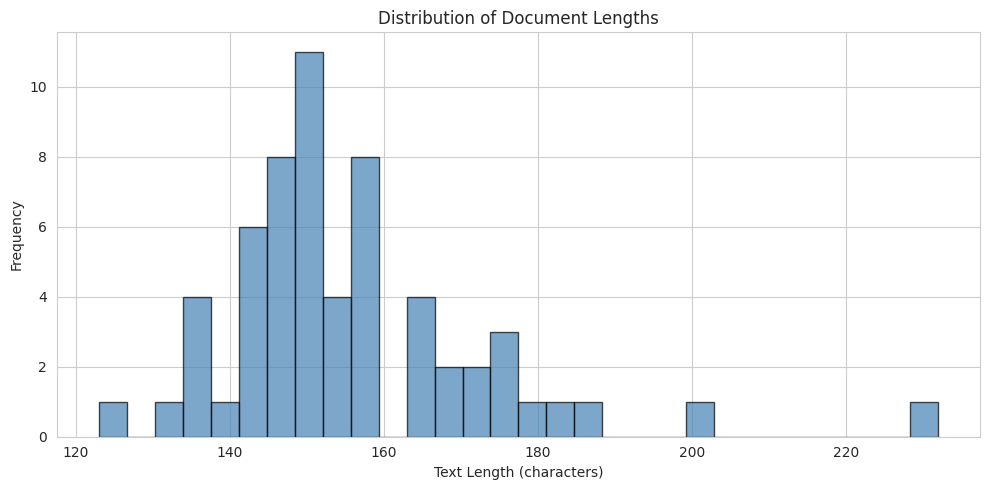

In [5]:
# Text length distribution
plt.figure(figsize=(10, 5))
plt.hist(df['text'].str.len(), bins=30, edgecolor='black', alpha=0.7, color='steelblue')
plt.xlabel('Text Length (characters)')
plt.ylabel('Frequency')
plt.title('Distribution of Document Lengths')
plt.tight_layout()
plt.show()

In [6]:
# ## 2. Quick Entity Extraction Test

#Test on Sample
sample_text = df.iloc[0]['text']
print("Sample text:")
print(sample_text)
print("\n" + "="*60 + "\n")

Sample text:
The rs429358 variant in the APOE gene is strongly associated with increased Alzheimer disease risk across multiple populations. This variant increases disease risk by approximately 3-fold in heterozygotes and 15-fold in homozygotes.




In [7]:
# Extract variants
variants = re.findall(r'\brs\d+\b', sample_text)
print(f"Variants found: {variants}")

# Extract gene-like tokens
genes = re.findall(r'\b[A-Z][A-Z0-9]{2,5}\b', sample_text)
genes = [g for g in genes if g not in ['THE', 'AND', 'FOR', 'WITH', 'RNA', 'DNA', 'USA']]
print(f"Potential genes: {genes}")

Variants found: ['rs429358']
Potential genes: ['APOE']


In [8]:
# Look for disease terms
disease_keywords = ['alzheimer', 'dementia', 'disease', 'disorder', 'cognitive', 'parkinson']
found_diseases = [kw for kw in disease_keywords if kw.lower() in sample_text.lower()]
print(f"Disease keywords: {found_diseases}")

Disease keywords: ['alzheimer', 'disease']


In [9]:
# ## 3. Build Entity Extractor

#Entity Extractor Class
class GenomicEntityExtractor:
    def __init__(self):
        self.variant_pattern = re.compile(r'\brs\d+\b')
        self.gene_pattern = re.compile(r'\b[A-Z][A-Z0-9]{2,5}\b')

        self.relations = [
            'associated with', 'linked to', 'increases risk',
            'affects', 'modulates', 'influences', 'causes',
            'contributes to', 'related to', 'implicated in'
        ]

        self.disease_terms = [
            'alzheimer', 'dementia', 'cognitive', 'parkinson',
            'disease', 'disorder', 'syndrome', 'impairment'
        ]

        self.gene_stopwords = {'THE', 'AND', 'FOR', 'WITH', 'RNA', 'DNA', 'USA', 'BUT', 'NOT'}

    def extract_variants(self, text):
        return list(set(self.variant_pattern.findall(text)))

    def extract_genes(self, text):
        candidates = self.gene_pattern.findall(text)
        return list(set([g for g in candidates if g not in self.gene_stopwords]))

    def extract_diseases(self, text):
        diseases = []
        text_lower = text.lower()

        # Find sentences with disease terms
        sentences = text.split('.')
        for sent in sentences:
            sent_lower = sent.lower()
            for term in self.disease_terms:
                if term in sent_lower:
                    # Extract capitalized phrases
                    words = sent.strip().split()
                    for i, word in enumerate(words):
                        if term in word.lower() and len(word) > 2:
                            # Get context window
                            start = max(0, i-2)
                            end = min(len(words), i+3)
                            phrase = ' '.join(words[start:end])
                            if len(phrase) > 5:
                                diseases.append(phrase.strip())

        return list(set(diseases))

    def extract_relations(self, text):
        found = []
        text_lower = text.lower()
        for rel in self.relations:
            if rel in text_lower:
                found.append(rel)
        return found

    def extract_all(self, text, text_id):
        variants = self.extract_variants(text)
        genes = self.extract_genes(text)
        diseases = self.extract_diseases(text)
        relations = self.extract_relations(text)

        records = []

        # Create combinations
        if variants and genes and diseases and relations:
            for variant in variants:
                for gene in genes:
                    for disease in diseases:
                        for relation in relations:
                            # Find evidence
                            sentences = text.split('.')
                            evidence = ""
                            for sent in sentences:
                                if variant in sent and gene in sent:
                                    evidence = sent.strip()
                                    break

                            records.append({
                                'text_id': text_id,
                                'variant': variant,
                                'gene': gene,
                                'phenotype': disease,
                                'relation': relation,
                                'evidence_span': evidence[:200]
                            })
        else:
            # Create partial records
            if variants or genes or diseases:
                records.append({
                    'text_id': text_id,
                    'variant': variants[0] if variants else None,
                    'gene': genes[0] if genes else None,
                    'phenotype': diseases[0] if diseases else None,
                    'relation': relations[0] if relations else None,
                    'evidence_span': text[:200]
                })

        return records

In [10]:
# ## 4. Extract Entities from All Texts

# Full Extraction
extractor = GenomicEntityExtractor()

all_entities = []
for idx, row in df.iterrows():
    entities = extractor.extract_all(row['text'], row['text_id'])
    all_entities.extend(entities)

entities_df = pd.DataFrame(all_entities)
print(f"\nExtracted {len(entities_df)} entity records")
print(f"From {len(df)} documents")

# Remove None values
entities_df = entities_df.dropna(subset=['variant', 'gene'])

print(f"After filtering: {len(entities_df)} records")
entities_df.head(10)


Extracted 97 entity records
From 60 documents
After filtering: 69 records


,text_id,variant,gene,phenotype,relation,evidence_span
0,T0001,rs429358,APOE,variant increases disease risk by,associated with,The rs429358 variant in the APOE gene is stron...
1,T0001,rs429358,APOE,with increased Alzheimer disease risk,associated with,The rs429358 variant in the APOE gene is stron...
2,T0001,rs429358,APOE,increased Alzheimer disease risk across,associated with,The rs429358 variant in the APOE gene is stron...
3,T0002,rs75932628,TREM2,late-onset Alzheimer disease,None,"Rare coding variants in TREM2, including rs759..."
4,T0003,rs744373,BIN1,with Alzheimer disease risk,associated with,Common variants near BIN1 at rs744373 are asso...
5,T0003,rs744373,BIN1,associated with Alzheimer disease risk,associated with,Common variants near BIN1 at rs744373 are asso...
6,T0004,rs11136000,CLU,to Alzheimer disease susceptibility,linked to,The clusterin gene CLU contains several varian...
7,T0004,rs11136000,CLU,to Alzheimer disease susceptibility,influences,The clusterin gene CLU contains several varian...
8,T0004,rs11136000,CLU,linked to Alzheimer disease susceptibility,linked to,The clusterin gene CLU contains several varian...
9,T0004,rs11136000,CLU,linked to Alzheimer disease susceptibility,influences,The clusterin gene CLU contains several varian...


In [11]:
# ## 5. Entity Analysis & Visualization

# Entity Statistics
print("="*60)
print("ENTITY STATISTICS")
print("="*60)

print("\nTop 10 Variants:")
print(entities_df['variant'].value_counts().head(10))

print("\nTop 10 Genes:")
print(entities_df['gene'].value_counts().head(10))

print("\nRelation Types:")
print(entities_df['relation'].value_counts())

print("\nTop Phenotypes:")
print(entities_df['phenotype'].value_counts().head(10))


ENTITY STATISTICS

Top 10 Variants:
variant
rs3851179     12
rs11136000     4
rs3865444      4
rs17125944     4
rs4420638      4
rs429358       3
rs11767557     3
rs242557       3
rs28834970     3
rs74615166     2
Name: count, dtype: int64

Top 10 Genes:
gene
APP       7
APOE      6
PICALM    6
CLU       4
CD33      4
FERMT2    4
EPHA1     3
PTK2B     3
MAPT      3
MS4A      2
Name: count, dtype: int64

Relation Types:
relation
associated with    21
linked to          17
affects             7
influences          6
modulates           5
implicated in       2
contributes to      2
Name: count, dtype: int64

Top Phenotypes:
phenotype
reduced Alzheimer disease risk                     6
with reduced Alzheimer disease risk                6
associated with Alzheimer disease risk             5
with Alzheimer disease risk through                3
linked to Alzheimer disease susceptibility         2
with Alzheimer disease risk                        2
contributes to Alzheimer disease susceptibi

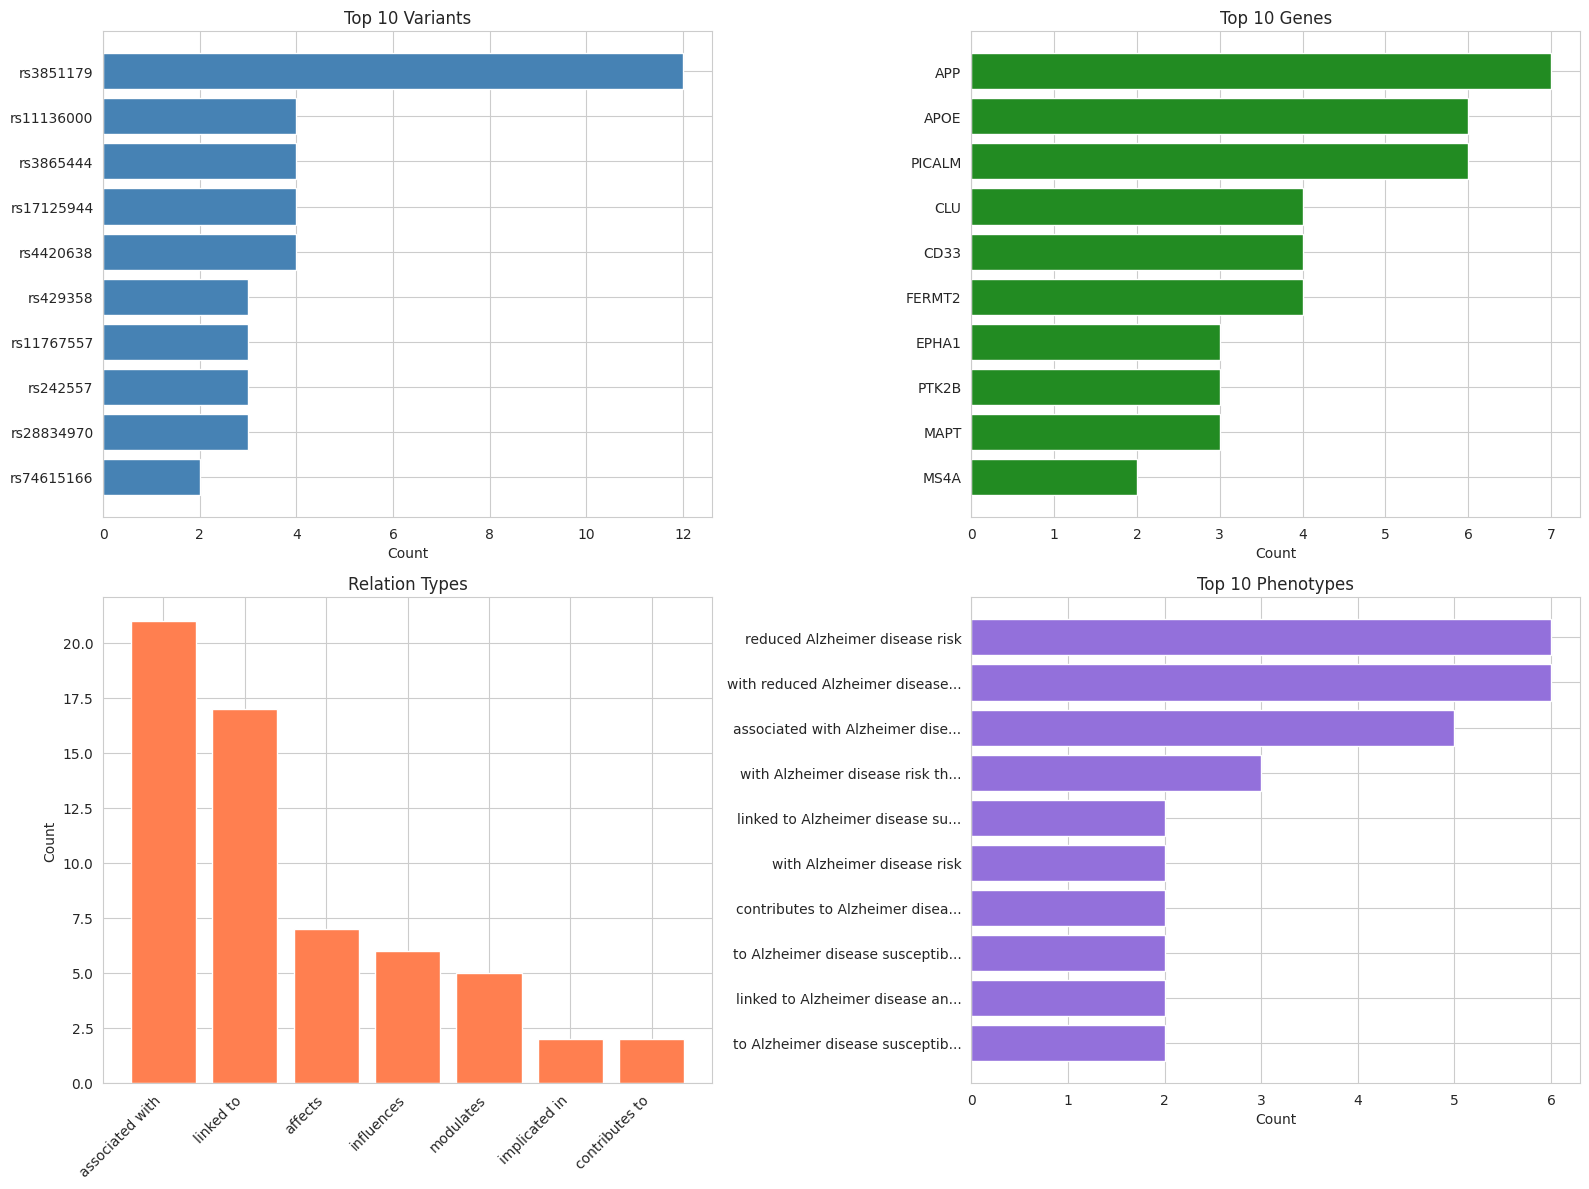

In [12]:
#Visualize Entities
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
# Top variants
top_variants = entities_df['variant'].value_counts().head(10)
axes[0, 0].barh(range(len(top_variants)), top_variants.values, color='steelblue')
axes[0, 0].set_yticks(range(len(top_variants)))
axes[0, 0].set_yticklabels(top_variants.index)
axes[0, 0].set_xlabel('Count')
axes[0, 0].set_title('Top 10 Variants')
axes[0, 0].invert_yaxis()

# Top genes
top_genes = entities_df['gene'].value_counts().head(10)
axes[0, 1].barh(range(len(top_genes)), top_genes.values, color='forestgreen')
axes[0, 1].set_yticks(range(len(top_genes)))
axes[0, 1].set_yticklabels(top_genes.index)
axes[0, 1].set_xlabel('Count')
axes[0, 1].set_title('Top 10 Genes')
axes[0, 1].invert_yaxis()

# Relations
relation_counts = entities_df['relation'].value_counts()
axes[1, 0].bar(range(len(relation_counts)), relation_counts.values, color='coral')
axes[1, 0].set_xticks(range(len(relation_counts)))
axes[1, 0].set_xticklabels(relation_counts.index, rotation=45, ha='right')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Relation Types')

# Top phenotypes
top_phenotypes = entities_df['phenotype'].value_counts().head(10)
axes[1, 1].barh(range(len(top_phenotypes)), top_phenotypes.values, color='mediumpurple')
axes[1, 1].set_yticks(range(len(top_phenotypes)))
axes[1, 1].set_yticklabels([p[:30] + '...' if len(p) > 30 else p for p in top_phenotypes.index])
axes[1, 1].set_xlabel('Count')
axes[1, 1].set_title('Top 10 Phenotypes')
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.show()

In [13]:
# ## 6. Topic Modeling - Find Optimal k

# Elbow Method
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

In [14]:
# Create TF-IDF features
vectorizer = TfidfVectorizer(
    max_features=200,
    stop_words='english',
    ngram_range=(1, 2),
    min_df=2
)
X = vectorizer.fit_transform(df['text'])

print(f"TF-IDF matrix shape: {X.shape}")

TF-IDF matrix shape: (60, 200)


In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
# Try different k values
inertias = []
silhouette_scores = []
K_range = range(2, 11)

from sklearn.metrics import silhouette_score

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    inertias.append(kmeans.inertia_)

    # Silhouette score (only if we have enough samples)
    if len(set(labels)) > 1:
        score = silhouette_score(X, labels)
        silhouette_scores.append(score)
    else:
        silhouette_scores.append(0)

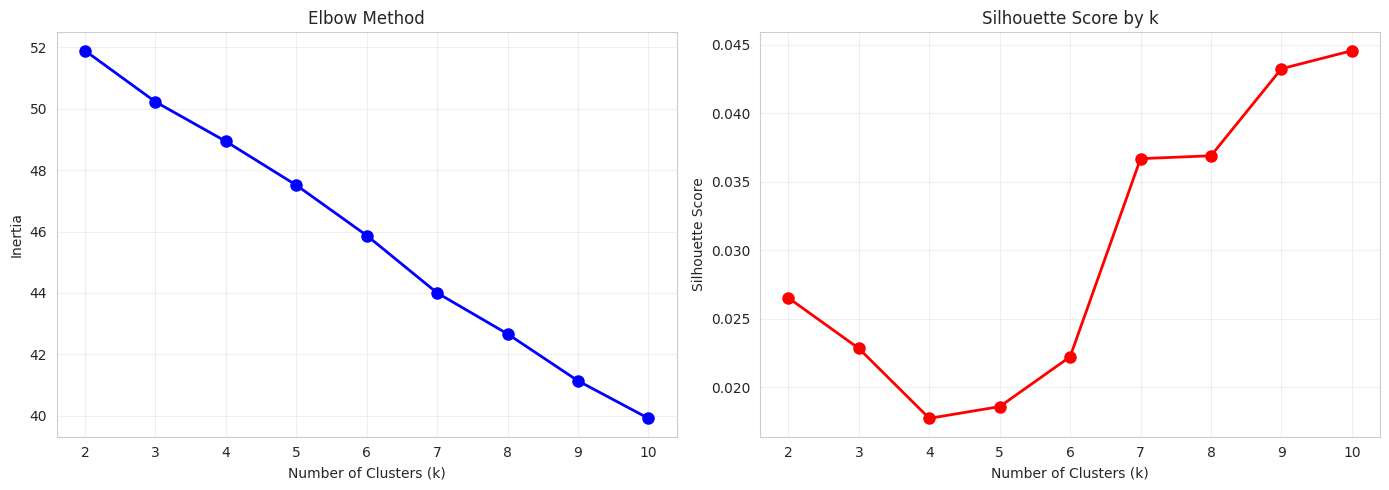

Best k by silhouette score: 10


In [17]:
# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method')
ax1.grid(True, alpha=0.3)

ax2.plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score by k')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Best k by silhouette score: {K_range[np.argmax(silhouette_scores)]}")

In [18]:
#7. Final Clustering with k=5

# Cluster Documents
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=20)
df['topic'] = kmeans.fit_predict(X)

# Topic distribution
topic_dist = df['topic'].value_counts().sort_index()
print("\nTopic Distribution:")
print(topic_dist)


Topic Distribution:
topic
0     9
1    22
2     7
3     5
4    17
Name: count, dtype: int64


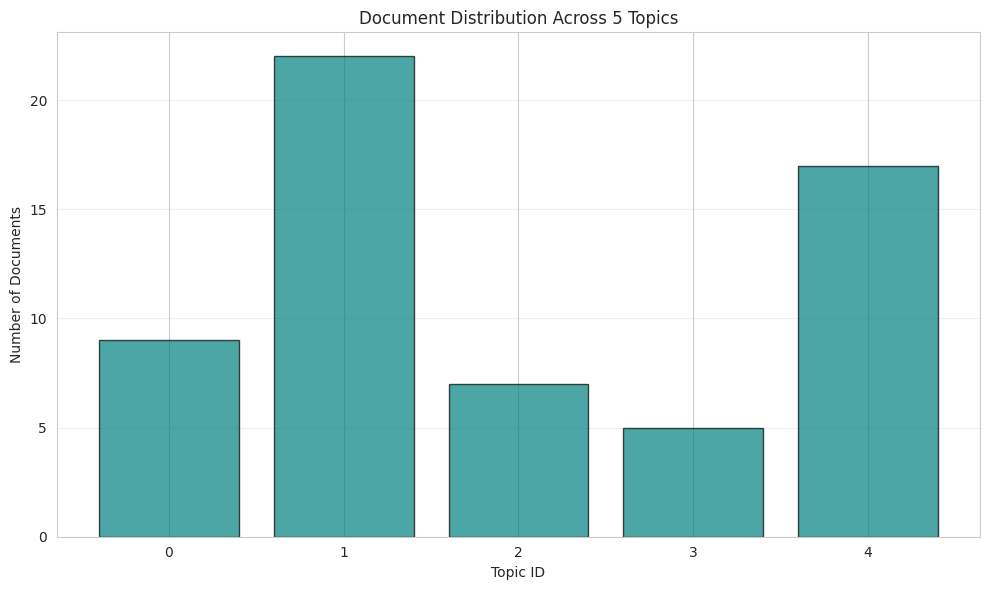

In [19]:
# Visualize distribution
plt.figure(figsize=(10, 6))
plt.bar(topic_dist.index, topic_dist.values, color='teal', alpha=0.7, edgecolor='black')
plt.xlabel('Topic ID')
plt.ylabel('Number of Documents')
plt.title(f'Document Distribution Across {n_clusters} Topics')
plt.xticks(topic_dist.index)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [20]:
# %% Topic Keywords
feature_names = vectorizer.get_feature_names_out()

print("\n" + "="*60)
print("TOPIC KEYWORDS")
print("="*60)

for i in range(n_clusters):
    center = kmeans.cluster_centers_[i]
    top_indices = center.argsort()[-15:][::-1]
    top_words = [feature_names[idx] for idx in top_indices]

    print(f"\nTopic {i} (n={topic_dist[i]} documents):")
    print(f"Keywords: {', '.join(top_words[:10])}")

    # Show 2 example texts
    examples = df[df['topic'] == i].head(2)
    for idx, row in examples.iterrows():
        print(f"  Example: {row['text'][:150]}...")


TOPIC KEYWORDS

Topic 0 (n=9 documents):
Keywords: linked, linked alzheimer, synaptic, neuronal, disease, alzheimer disease, alzheimer, variants, cognitive decline, decline
  Example: The clusterin gene CLU contains several variants including rs11136000 that are linked to Alzheimer disease susceptibility. Clusterin influences amyloi...
  Example: The protein tyrosine kinase PTK2B contains variant rs28834970 linked to cognitive decline and Alzheimer disease. PTK2B regulates calcium signaling in ...

Topic 1 (n=22 documents):
Keywords: genetic, ad, variants, including, loci, abca7, genetic variants, populations, risk, ad risk
  Example: Loss-of-function variants in ABCA7, including rs3764650, increase AD susceptibility. ABCA7 regulates lipid homeostasis and affects amyloid processing ...
  Example: Large-scale genome-wide association study meta-analysis identified 29 risk loci for Alzheimer disease including ZCWPW1, ADAMTS1, and HESX1 variants at...

Topic 2 (n=7 documents):
Keywords: c

In [21]:
# ## 8. Visualize Clusters in 2D (PCA)

#PCA Visualization
from sklearn.decomposition import PCA

# Reduce to 2D
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X.toarray())

print(f"Explained variance: {pca.explained_variance_ratio_.sum():.2%}")

Explained variance: 9.88%


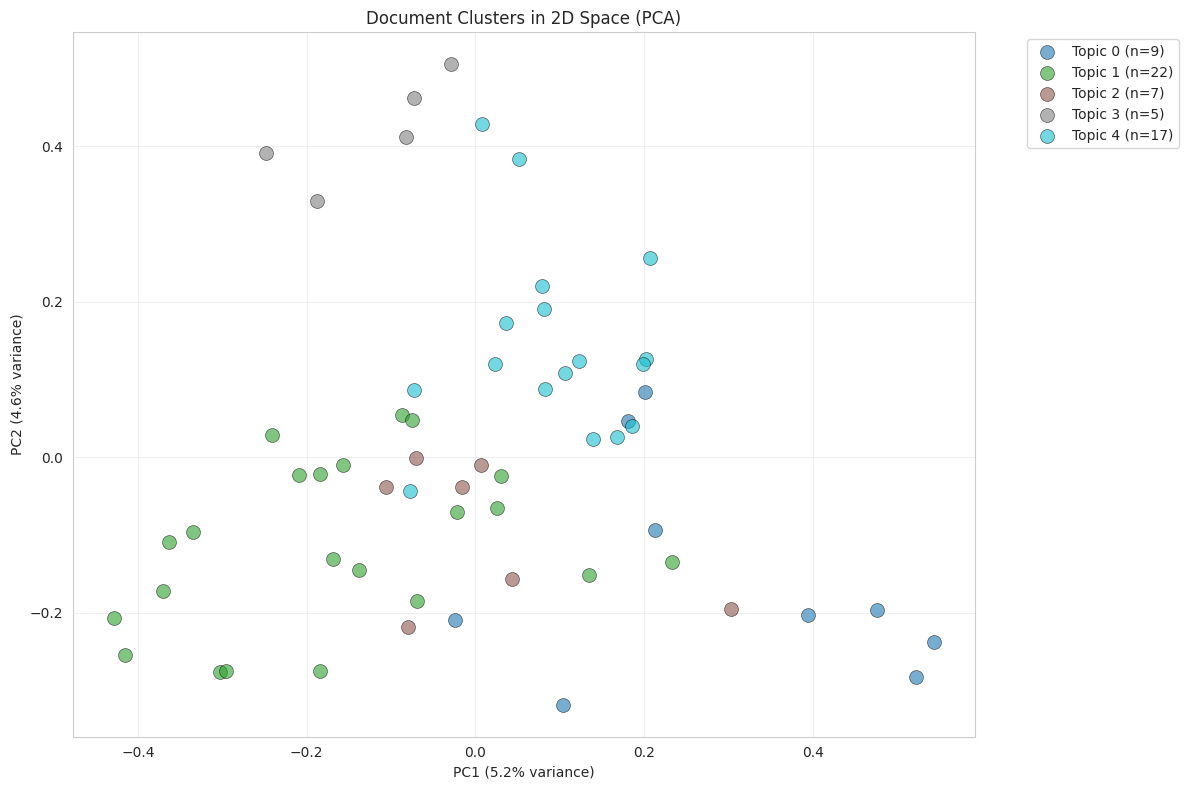

In [22]:
# Plot
plt.figure(figsize=(12, 8))
colors = plt.cm.tab10(np.linspace(0, 1, n_clusters))

for i in range(n_clusters):
    mask = df['topic'] == i
    plt.scatter(
        X_2d[mask, 0],
        X_2d[mask, 1],
        c=[colors[i]],
        label=f'Topic {i} (n={sum(mask)})',
        alpha=0.6,
        s=100,
        edgecolors='black',
        linewidth=0.5
    )

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.title('Document Clusters in 2D Space (PCA)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Creating semantic embeddings...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Reducing dimensions with UMAP...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


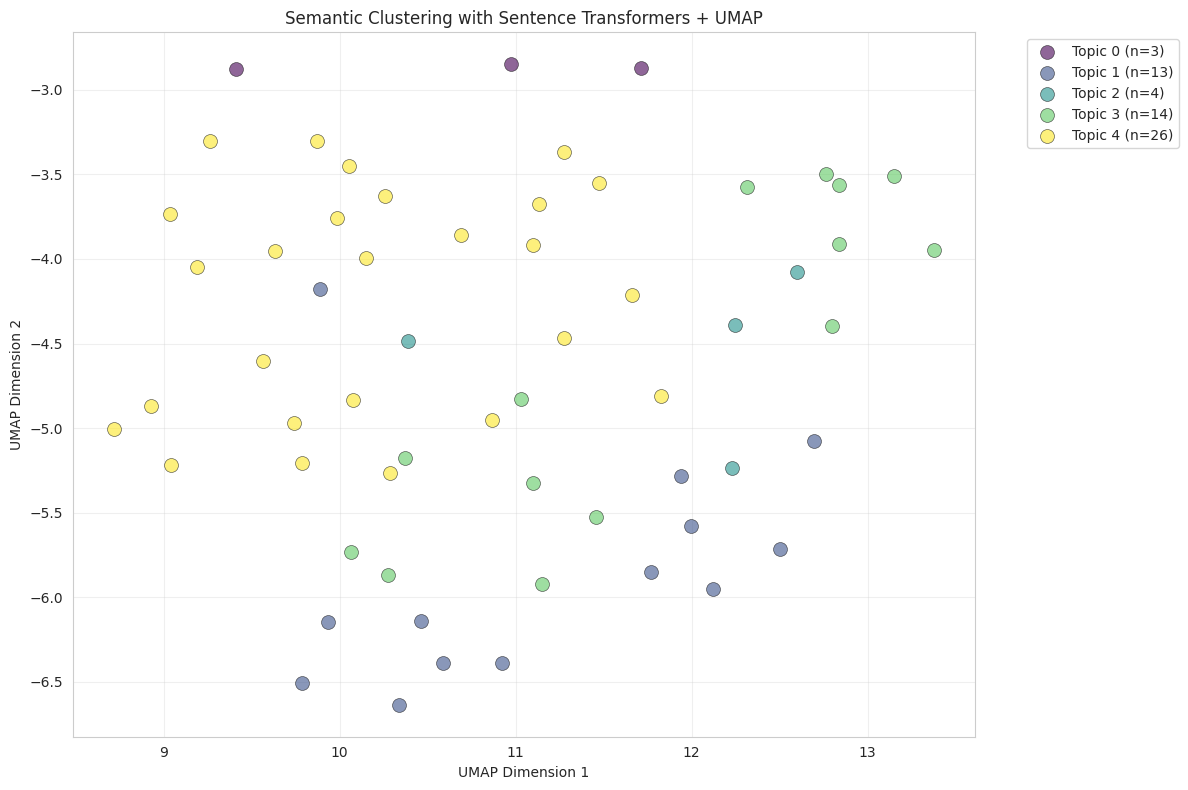


Semantic clustering complete!


In [23]:
# ## 9. Advanced: Semantic Embeddings with UMAP

# Sentence Transformers

try:
    from sentence_transformers import SentenceTransformer
    import umap

    print("Creating semantic embeddings...")
    model = SentenceTransformer('all-MiniLM-L6-v2')
    embeddings = model.encode(df['text'].tolist(), show_progress_bar=True)

    print("Reducing dimensions with UMAP...")
    reducer = umap.UMAP(
        n_components=2,
        random_state=42,
        n_neighbors=15,
        min_dist=0.1,
        metric='cosine'
    )
    embeddings_2d = reducer.fit_transform(embeddings)

    # Re-cluster on embeddings
    kmeans_emb = KMeans(n_clusters=n_clusters, random_state=42)
    df['topic_semantic'] = kmeans_emb.fit_predict(embeddings)

    # Plot
    plt.figure(figsize=(12, 8))
    colors = plt.cm.viridis(np.linspace(0, 1, n_clusters))

    for i in range(n_clusters):
        mask = df['topic_semantic'] == i
        plt.scatter(
            embeddings_2d[mask, 0],
            embeddings_2d[mask, 1],
            c=[colors[i]],
            label=f'Topic {i} (n={sum(mask)})',
            alpha=0.6,
            s=100,
            edgecolors='black',
            linewidth=0.5
        )

    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.title('Semantic Clustering with Sentence Transformers + UMAP')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    print("\nSemantic clustering complete!")

except ImportError:
    print("\nSkipping semantic embeddings (sentence-transformers not installed)")
    print("To enable: pip install sentence-transformers umap-learn")


In [24]:
# ## 10. Save Results

# Export Data
# Create output directory
Path('../output').mkdir(exist_ok=True)

# Save entities
entities_df.to_csv('../output/entities.csv', index=False)
entities_df.to_json('../output/entities.json', orient='records', indent=2)

# Save clustered documents
df.to_csv('../output/texts_with_topics.csv', index=False)

# Create topic summary
topic_summary = []
for i in range(n_clusters):
    center = kmeans.cluster_centers_[i]
    top_indices = center.argsort()[-10:][::-1]
    top_words = [feature_names[idx] for idx in top_indices]

    topic_summary.append({
        'topic_id': i,
        'size': int(topic_dist[i]),
        'keywords': top_words,
        'example_texts': df[df['topic'] == i]['text'].head(3).tolist()
    })

import json
with open('../output/topics.json', 'w') as f:
    json.dump(topic_summary, f, indent=2)

print("\n" + "="*60)
print("RESULTS SAVED")
print("="*60)
print("✓ entities.csv")
print("✓ entities.json")
print("✓ texts_with_topics.csv")
print("✓ topics.json")


RESULTS SAVED
✓ entities.csv
✓ entities.json
✓ texts_with_topics.csv
✓ topics.json


In [25]:
# Final Summary
print("\n" + "="*60)
print("PIPELINE SUMMARY")
print("="*60)
print(f"📊 Documents processed: {len(df)}")
print(f"🔍 Entity records extracted: {len(entities_df)}")
print(f"   - Unique variants: {entities_df['variant'].nunique()}")
print(f"   - Unique genes: {entities_df['gene'].nunique()}")
print(f"   - Unique phenotypes: {entities_df['phenotype'].nunique()}")
print(f"🧠 Topics identified: {n_clusters}")
print(f"📈 Visualizations created: 5+")
print("\n✅ Analysis complete!")


PIPELINE SUMMARY
📊 Documents processed: 60
🔍 Entity records extracted: 69
   - Unique variants: 30
   - Unique genes: 28
   - Unique phenotypes: 38
🧠 Topics identified: 5
📈 Visualizations created: 5+

✅ Analysis complete!
